  # Chamber Analysis

In this example we'll start to look at the aerosols in a smog chamber with a focus on how the size distributions evolves with time. The example data is from a NaCl aerosol experiment in a smog chamber (900 L).

The Experiment:

After injection of NaCl particles, the chamber was only slowly purged with clean air, so the aerosols would be pushed out to the instruments. The clean air flow was 1.25 LPM (1 SLPM). No chemistry was happening in the chamber, so the aerosol size distribution should be stable from a condensation point of view. The aerosol distribution should change due to coagulation and wall losses.

Let's start by loading the data and plotting the size distribution.

In [1]:
# all the imports
import numpy as np
import matplotlib.pyplot as plt
from particula.data import loader_interface, settings_generator
from particula.data.tests.example_data.get_example_data import get_data_folder

from particula.util import convert
# set the parent directory of the data folders
path = get_data_folder()
print('Path to data folder:')
print(path.rsplit('particula')[-1])

Path to data folder:
\data\tests\example_data


 ### Load the data
 We'll uses the settings from the Data loading examples, to load the Scanning Mobility Particle Sizer (SMPS) data.

In [2]:
# load the 1d data
smps_1d_stream_settings = settings_generator.load_settings_for_stream(
    path=path,
    subfolder='chamber_data',
    settings_suffix='_smps_1d',
)

stream_smps_1d = loader_interface.load_files_interface(
    path=path,
    settings=smps_1d_stream_settings
)

# load the 2d data
smps_2d_stream_settings = settings_generator.load_settings_for_stream(
    path=path,
    subfolder='chamber_data',
    settings_suffix='_smps_2d',
)

stream_smps_2d = loader_interface.load_files_interface(
    path=path,
    settings=smps_2d_stream_settings
)

print(stream_smps_1d.header)

  Loading file: 2023-09-25_160155_SMPS.csv
  Loading file: 2023-09-25_160155_SMPS.csv
['Lower_Size_(nm)', 'Upper_Size_(nm)', 'Sample_Temp_(C)', 'Sample_Pressure_(kPa)', 'Relative_Humidity_(%)', 'Median_(nm)', 'Mean_(nm)', 'Geo_Mean_(nm)', 'Mode_(nm)', 'Geo_Std_Dev.', 'Total_Conc_(#/cc)']


## Pause to Plot
Let's pause to plot the data. We'll plot the size distribution at the start and end of the experiment.

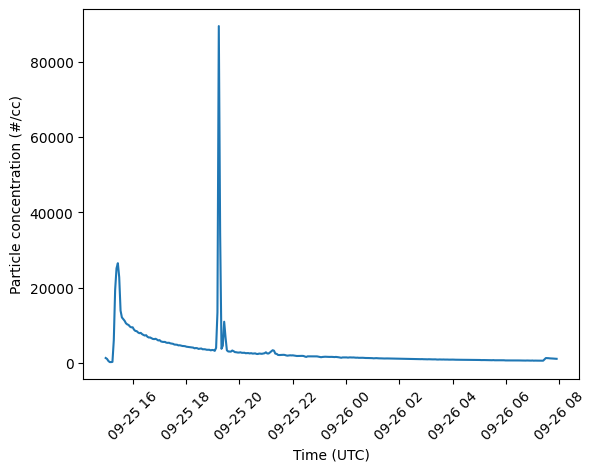

In [6]:
# plot the 1d data
fig, ax = plt.subplots()
ax.plot(
    stream_smps_1d.datetime64,
    stream_smps_1d['Total_Conc_(#/cc)'],
    label='Concentration'
)
plt.xticks(rotation=45)
ax.set_xlabel("Time (UTC)")
ax.set_ylabel('Particle concentration (#/cc)')
plt.show()
fig.tight_layout()

## Clean up the data

Now their are a couple things we need to account for from the raw data.

1. The SMPS data is in dN/dlogDp, but we want dN/dDp. So we need to convert the data.
2. The SMPS sample line was diluted 1:2 with clean air, so we need to account for that.
3. We need to select from after the injection starts and before the chamber is purged (that small bump at the end of the data).
4. Then we need to remove those couple scans where data jumps crazy high (due to a cpc malfunction), around 1900.

In [7]:
# 1 convert to dn/dlogDp

stream_smps_2d.data = convert.convert_sizer_dn(
    diameter=np.array(stream_smps_2d.header, dtype=float),
    dn_dlogdp=stream_smps_2d.data,
)

# Dilution correction
dilution_correction = 2

# scale the concentrations
stream_smps_2d.data *= dilution_correction
stream_smps_1d['Total_Conc_(#/cc)'] *= dilution_correction

## Plot the distributions

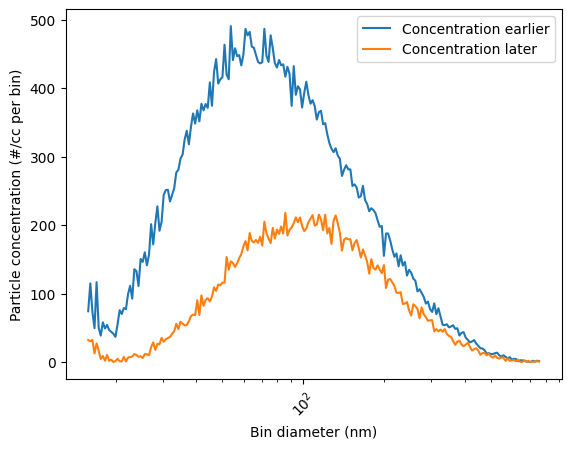

In [23]:
# plot the 2d data
fig, ax = plt.subplots()
ax.plot(
    stream_smps_2d.header_float,
    stream_smps_2d.data[:, 10],
    label='Concentration earlier'
)
ax.plot(
    stream_smps_2d.header_float,
    stream_smps_2d.data[:, 20],
    label='Concentration later'
)
ax.set_xscale('log')
plt.xticks(rotation=45)
ax.set_xlabel("Bin diameter (nm)")
ax.set_ylabel('Particle concentration (#/cc per bin)')
plt.legend()
plt.show()
fig.tight_layout()